# Deer Prediction

The end goal for this work would be to identify locations where there is a chance of overlap between deer and humans. This would be a location/time overlap that is based off of deer density over time and human density over time.

Using the GPS we are able to create deer density over time for a subset of deer. Using this sampled density and environmental features we can estimate locations that deer would go to. To do this an area of interest was selected (Howard County) and a 100m hexagonal grid was created for the area. Deer density was generated for the grid and additional features sampled for each grid cell. The environmetal features included were:

* **Open Street Map**:
  * Area of building footprints per cell
  * Length of large highways per cell
  * Length of asphalt roads per cell
* **National Land Cover Database**:
  * Average/min/max canopy area per cell
  * Average/min/max impervious surface per cell
 



In [1]:
# ! pip install owslib

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import plotly.express as px
import datetime
import json

from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GroupShuffleSplit 

In [19]:
# Variables and things to use for setting up this ML train/test/run script

cfg = {}
cfg['control'] = {'save_pkl':False,
                  'plot_results': True}
cfg['process_timestamp'] = datetime.datetime.now().isoformat()
cfg['classifier'] = {}
cfg['classifier']['algorithm'] = ['LightGBM','Dart','CatBoost']
cfg['classifier']['features_to_use'] = ['canopy_mean', 
                                        'canopy_max', 
                                        'canopy_min',
                                        'canopy_stddev', 
                                        'surface_mean', 
                                        'surface_max', 
                                        'surface_min',
                                        'surface_stddev', 
                                        'built_area', 
                                        'asphalt_length', 
                                        'highway_length',
                                        'pop_total', 
                                        'LISA_I_Surface',
                                       'LISA_CL_Surface', 'LISA_P_Surface', 'LISA_I_Canopy', 'LISA_CL_Canopy',
                                       'LISA_P_Canopy', 'LISA_I_Pop', 'LISA_CL_Pop', 'LISA_P_Pop',
                                       'LISA_I_Built', 'LISA_CL_Built', 'LISA_P_Built', 'LISA_I_Asphalt',
                                       'LISA_CL_Asphalt', 'LISA_P_Asphalt', 'LISA_I_Hway', 'LISA_CL_Hway',
                                       'LISA_P_Hway'
                                       
                                       ]
cfg['classifier']['split-ratio'] = 0.5
cfg['classifier']['target-variable'] = ['Label']
cfg['plot_labels']={ 
         "individual": "Individual ID",
         "timestamp": "Timestamp without time zone.",
         "time": "Time of Day",
         "time_delta_hours": "Interval between samples",
         "geom_delta_meters": "Distance between samples",
         "meters_per_hour" : "Travel Speed [m/h]" }

cfg['files'] = {'features':'./data/geoda/ml_features.parq',
                'env_gpkg': './data/geoda/geoda_out_60m.gpkg',
                'full_predictions': './data/geoda/ml_predictions.gpkg',
                'results':'./data/results.pkl'}

In [4]:
cfg

{'control': {'save_pkl': False, 'plot_results': True},
 'process_timestamp': '2024-08-27T15:19:27.378002',
 'classifier': {'algorithm': ['LightGBM', 'Dart', 'CatBoost'],
  'features_to_use': ['canopy_mean',
   'canopy_max',
   'canopy_min',
   'canopy_stddev',
   'surface_mean',
   'surface_max',
   'surface_min',
   'surface_stddev',
   'built_area',
   'asphalt_length',
   'highway_length',
   'pop_total',
   'LISA_I_Surface',
   'LISA_CL_Surface',
   'LISA_P_Surface',
   'LISA_I_Canopy',
   'LISA_CL_Canopy',
   'LISA_P_Canopy',
   'LISA_I_Pop',
   'LISA_CL_Pop',
   'LISA_P_Pop',
   'LISA_I_Built',
   'LISA_CL_Built',
   'LISA_P_Built',
   'LISA_I_Asphalt',
   'LISA_CL_Asphalt',
   'LISA_P_Asphalt',
   'LISA_I_Hway',
   'LISA_CL_Hway',
   'LISA_P_Hway'],
  'split-ratio': 0.5,
  'target-variable': ['Label']},
 'plot_labels': {'individual': 'Individual ID',
  'timestamp': 'Timestamp without time zone.',
  'time': 'Time of Day',
  'time_delta_hours': 'Interval between samples',
  'geom_

In [5]:
# df2 = pd.read_csv('./data/ml_hex.csv')
df = pd.read_parquet(cfg['files']['features'])
df = df.fillna(0)
df['Label'] = np.select(
    [
        df['avg_speed'].between(0, 0.001, inclusive = 'both'), 
        # df['avg_speed'].between(0.001, 400, inclusive='right'),
        df['avg_speed'].ge(0.001)
    ], 
    [
        'Avoid', 
        # 'At Rest',
        'Active'
    ], 
    default='Unknown'
)

In [6]:
df.columns

Index(['index_left', 'asphalt_length', 'built_area', 'canopy_max',
       'canopy_mean', 'canopy_min', 'canopy_stddev', 'gid', 'highway_length',
       'id_x', 'pop_total', 'surface_max', 'surface_mean', 'surface_min',
       'surface_stddev', 'LISA_I', 'LISA_CL', 'LISA_P', 'LISA_I_Surface',
       'LISA_CL_Surface', 'LISA_P_Surface', 'LISA_I_Canopy', 'LISA_CL_Canopy',
       'LISA_P_Canopy', 'LISA_I_Pop', 'LISA_CL_Pop', 'LISA_P_Pop',
       'LISA_I_Built', 'LISA_CL_Built', 'LISA_P_Built', 'LISA_I_Asphalt',
       'LISA_CL_Asphalt', 'LISA_P_Asphalt', 'LISA_I_Hway', 'LISA_CL_Hway',
       'LISA_P_Hway', 'geometry_x', 'deer_id_x', 'index_right',
       'age_at_deployment', 'collar', 'collar_id', 'month', 'park_name', 'sex',
       'year', 'index', 'avg_speed', 'deer_id_y', 'id_y', 'time_in_grid',
       'track_count', 'Label'],
      dtype='object')

In [7]:
splitter = GroupShuffleSplit(test_size=cfg['classifier']['split-ratio'], n_splits=2, random_state = 23)
split = splitter.split(df, groups=df['gid'])
train_inds, test_inds = next(split)

train2 = df.iloc[train_inds]
test2 = df.iloc[test_inds]
x_train = train2[cfg['classifier']['features_to_use']]
x_test = test2[cfg['classifier']['features_to_use']]
y_train = train2[cfg['classifier']['target-variable']]
y_test = test2[cfg['classifier']['target-variable']]

In [8]:
test_data = catboost_pool = Pool(x_test,
                                 y_test)

model_catboost = CatBoostClassifier(
                           # iterations=2,
                           # depth=2,
                           learning_rate=0.03,
                           loss_function='MultiClass',
                           auto_class_weights='Balanced',
                           # verbose=True
                           )
# train the model
model_catboost.fit(x_train, y_train, eval_set=(x_test,y_test), plot=True)
# make the prediction using the resulting model
preds_class = model_catboost.predict(test_data)
preds_proba = model_catboost.predict_proba(test_data)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6843139	test: 0.6845391	best: 0.6845391 (0)	total: 58.9ms	remaining: 58.8s
1:	learn: 0.6756270	test: 0.6759369	best: 0.6759369 (1)	total: 73.7ms	remaining: 36.8s
2:	learn: 0.6670406	test: 0.6673362	best: 0.6673362 (2)	total: 86ms	remaining: 28.6s
3:	learn: 0.6592193	test: 0.6597384	best: 0.6597384 (3)	total: 99.4ms	remaining: 24.8s
4:	learn: 0.6517679	test: 0.6525235	best: 0.6525235 (4)	total: 110ms	remaining: 22s
5:	learn: 0.6448747	test: 0.6460002	best: 0.6460002 (5)	total: 123ms	remaining: 20.3s
6:	learn: 0.6385783	test: 0.6399300	best: 0.6399300 (6)	total: 136ms	remaining: 19.4s
7:	learn: 0.6315228	test: 0.6329570	best: 0.6329570 (7)	total: 148ms	remaining: 18.4s
8:	learn: 0.6251848	test: 0.6267471	best: 0.6267471 (8)	total: 161ms	remaining: 17.8s
9:	learn: 0.6186781	test: 0.6203923	best: 0.6203923 (9)	total: 175ms	remaining: 17.3s
10:	learn: 0.6128351	test: 0.6149246	best: 0.6149246 (10)	total: 187ms	remaining: 16.8s
11:	learn: 0.6075625	test: 0.6100483	best: 0.6100483

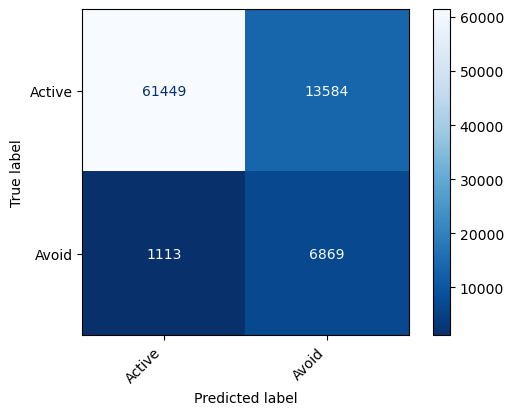

In [9]:

disp = ConfusionMatrixDisplay.from_predictions(y_test, preds_class, cmap='Blues_r',normalize=None)
fig = disp.ax_.get_figure() 
fig.autofmt_xdate(rotation=45)

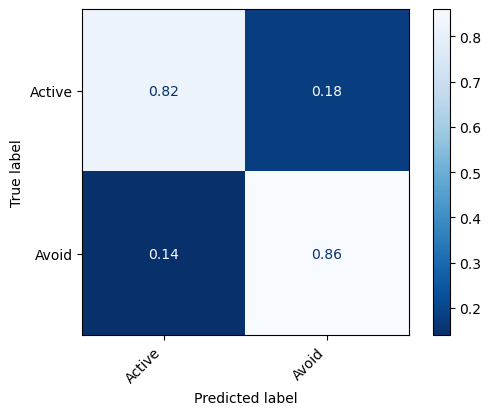

In [10]:
# y_pred = model.predict(x_test) 
disp = ConfusionMatrixDisplay.from_predictions(y_test, preds_class, cmap='Blues_r',normalize='true')
fig = disp.ax_.get_figure() 
fig.autofmt_xdate(rotation=45)

/opt/conda/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/conda/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


<Axes: xlabel='Iterations', ylabel='MultiClass Log-loss'>

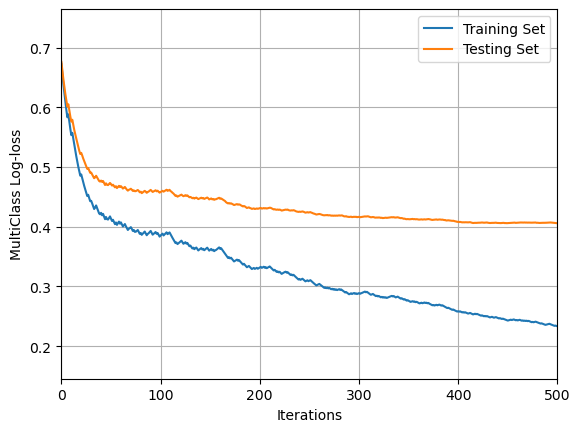

In [11]:
model_lgbm = lgb.LGBMClassifier( 
                           boosting_type = 'dart',
                           num_leaves = 31,
                           max_depth = -1, 
                           class_weight = 'balanced',
                           learning_rate = 0.05,
                           n_estimators = 500,
                           verbose = -1)
model_lgbm.fit(x_train,
          y_train,
          eval_set=[(x_test,y_test),(x_train,y_train)])

metric_ax = lgb.plot_metric(model_lgbm, 
                xlabel='Iterations', 
                ylabel='MultiClass Log-loss',
                title = '') 

handles, previous_labels = metric_ax.get_legend_handles_labels()
previous_labels
new_labels = ['Training Set', 'Testing Set']
metric_ax.legend(handles=handles, labels=new_labels)
metric_ax

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

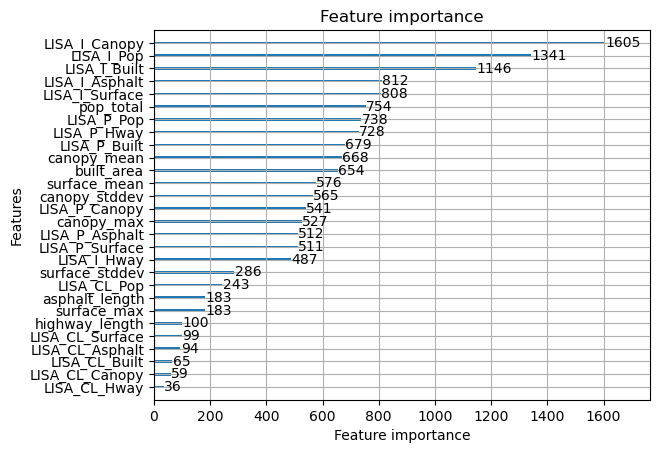

In [12]:
lgb.plot_importance(model_lgbm)

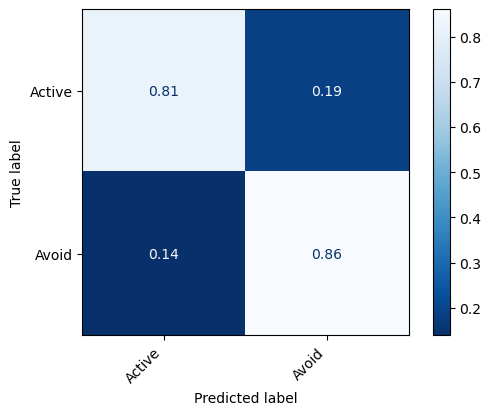

In [13]:
y_pred = model_lgbm.predict(x_test) 
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues_r',normalize='true')
fig = disp.ax_.get_figure() 
fig.autofmt_xdate(rotation=45)

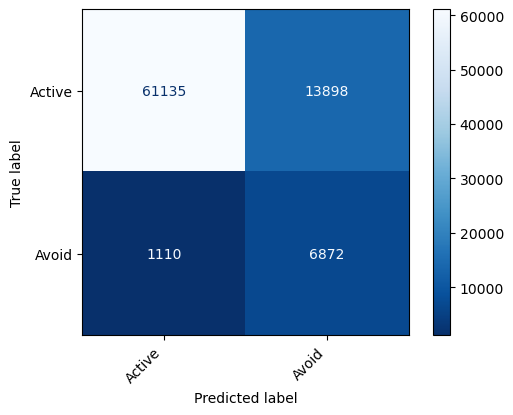

In [14]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues_r')
fig = disp.ax_.get_figure() 
fig.autofmt_xdate(rotation=45)

## Infer the Deer Activity for all areas in Howard County

In [15]:
import geopandas as gpd

In [22]:
gdf = gpd.read_file(cfg['files']['env_gpkg'])

In [23]:
gdf['Prediction_CatBoost'] =  model_catboost.predict(gdf[cfg['classifier']['features_to_use']]).squeeze() # LGBM and CatBoost return different shaped arrays...
gdf['Prediction_LGBM'] =  model_lgbm.predict(gdf[cfg['classifier']['features_to_use']]) 

In [24]:
gdf.to_file(cfg['files']['full_predictions'], layer='env', driver="GPKG")

In [25]:
gdf

,index,asphalt_length,built_area,canopy_max,canopy_mean,canopy_min,canopy_stddev,gid,highway_length,id,...,LISA_P_Built,LISA_I_Asphalt,LISA_CL_Asphalt,LISA_P_Asphalt,LISA_I_Hway,LISA_CL_Hway,LISA_P_Hway,geometry,Prediction_CatBoost,Prediction_LGBM
0,0,0.000000,0.000000,0,0.0,0,0.0,1,0.000000,1,...,0.001,-0.177626,3,0.005,-0.281831,3,0.001,"POLYGON ((-77.20016 39.09142, -77.1998 39.0909...",Avoid,Avoid
1,1,0.000000,1170.674948,0,0.0,0,0.0,2,0.000000,2,...,0.001,-0.177626,3,0.008,-0.281831,3,0.001,"POLYGON ((-77.20019 39.09236, -77.19983 39.091...",Avoid,Avoid
2,2,0.000000,4491.105042,0,0.0,0,0.0,3,0.000000,3,...,0.001,-0.165520,3,0.012,-0.277052,3,0.001,"POLYGON ((-77.20022 39.0933, -77.19985 39.0928...",Avoid,Avoid
3,3,0.000000,940.170939,0,0.0,0,0.0,4,0.000000,4,...,0.001,-0.231448,3,0.003,-0.222944,3,0.002,"POLYGON ((-77.20024 39.09423, -77.19988 39.093...",Avoid,Avoid
4,4,0.000000,0.000000,0,0.0,0,0.0,5,136.934268,5,...,0.001,-0.190396,3,0.003,0.851434,1,0.010,"POLYGON ((-77.20027 39.09517, -77.19991 39.094...",Avoid,Avoid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148350,8350,0.000000,1235.820710,0,0.0,0,0.0,148351,0.000000,148351,...,0.001,-0.195274,3,0.003,-0.085348,0,0.056,"POLYGON ((-76.69083 39.37522, -76.69047 39.374...",Avoid,Avoid
148351,8351,114.525639,1487.133942,0,0.0,0,0.0,148352,114.525639,148352,...,0.001,0.514665,1,0.011,0.122837,0,0.249,"POLYGON ((-76.69085 39.37615, -76.69049 39.375...",Avoid,Avoid
148352,8352,208.205962,2301.511095,0,0.0,0,0.0,148353,0.000000,148353,...,0.001,0.699608,1,0.039,0.009308,0,0.493,"POLYGON ((-76.69088 39.37709, -76.69052 39.376...",Avoid,Avoid
148353,8353,137.068136,1604.573085,0,0.0,0,0.0,148354,0.000000,148354,...,0.001,0.396862,1,0.044,0.009308,0,0.465,"POLYGON ((-76.6909 39.37803, -76.69054 39.3775...",Avoid,Avoid
